### Penguins 데이터에 Optuna 적용

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00


In [3]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [4]:
# 데이터 로드 & 전처리
import seaborn as sns
df = sns.load_dataset("penguins")

df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [5]:
df.dropna(inplace=True)

df.drop(columns=['island'], inplace=True)

df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})
df['species'] = df['species'].map({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})

X = df.drop(columns=['species'])
y = df['species']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Optuna 목적 함수 정의
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 10)  # 2~10 범위
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)  # 2~6 범위

    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    return accuracy_score(y_test, y_pred)  # 정확도 리턴


In [8]:
# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 50번 반복 최적화

[I 2025-03-05 07:16:48,241] A new study created in memory with name: no-name-d7cbb9a8-d1c4-4546-9505-e24f48e956c5
[I 2025-03-05 07:16:48,252] Trial 0 finished with value: 0.9850746268656716 and parameters: {'max_depth': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.9850746268656716.
[I 2025-03-05 07:16:48,260] Trial 1 finished with value: 0.9850746268656716 and parameters: {'max_depth': 6, 'min_samples_split': 6}. Best is trial 0 with value: 0.9850746268656716.
[I 2025-03-05 07:16:48,269] Trial 2 finished with value: 0.9850746268656716 and parameters: {'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: 0.9850746268656716.
[I 2025-03-05 07:16:48,278] Trial 3 finished with value: 0.9850746268656716 and parameters: {'max_depth': 4, 'min_samples_split': 3}. Best is trial 0 with value: 0.9850746268656716.
[I 2025-03-05 07:16:48,286] Trial 4 finished with value: 0.9850746268656716 and parameters: {'max_depth': 4, 'min_samples_split': 3}. Best is trial 0 with val

In [9]:
# 최적 파라미터 확인
print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best trial:
Value: 1.0
Params: 
  max_depth: 7
  min_samples_split: 3


In [12]:
# 최적 모델 학습 & 평가
best_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=trial.params['max_depth'],
    min_samples_split=trial.params['min_samples_split'],
    random_state=42
)

best_dt.fit(X_train, y_train)
y_pred_best = best_dt.predict(X_test)

In [14]:
# 최적 모델 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error

In [15]:
# 최적 모델 평가
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best, average='macro')
best_recall = recall_score(y_test, y_pred_best, average='macro')
best_mse = mean_squared_error(y_test, y_pred_best)

# 결과 출력
print("\n 최적 모델 평가 결과")
print("Best Decision Tree Accuracy (Test): {:.4f}".format(best_accuracy))
print("Precision (정밀도): {:.4f}".format(best_precision))
print("Recall (재현율): {:.4f}".format(best_recall))
print("Mean Squared Error (MSE): {:.4f}".format(best_mse))


 최적 모델 평가 결과
Best Decision Tree Accuracy (Test): 1.0000
Precision (정밀도): 1.0000
Recall (재현율): 1.0000
Mean Squared Error (MSE): 0.0000


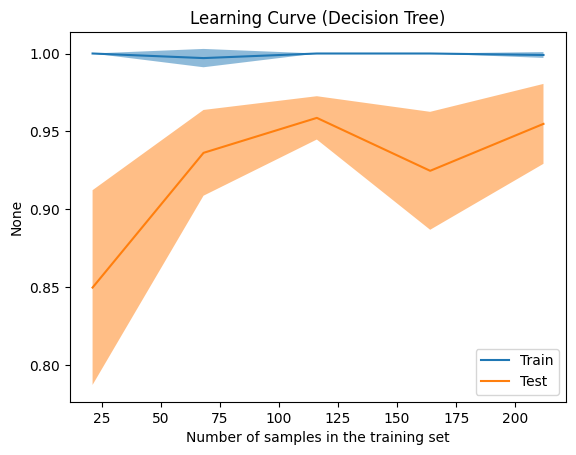

In [17]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# 학습곡선을 출력하시오.

# 학습 곡선 생성
train_sizes, train_scores, test_scores = learning_curve(
    best_dt, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

# 학습 곡선 시각화
LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores,
                     test_scores=test_scores).plot()
plt.title('Learning Curve (Decision Tree)')
plt.show()


1. 분석 결과

과적합 가능성 높음: 훈련 정확도는 100%에 가깝지만, 테스트 정확도는 변동성 존재함.

일반화 부족: 데이터 크기에 따라 성능이 변화하며, 일부 구간에서 테스트 성능이 하락함.

2. 개선 방안

가지치기(Pruning) 강화: max_depth를 2~7 범위로 조정하여 과적합 방지.

데이터 확장 고려: 훈련 데이터 크기를 늘려 모델의 일반화 성능 향상.

교차 검증(K-Fold CV) 강화: cv=10으로 설정 -> 모델의 안정성을 높임.

3. 결론

현재 모델은 과적합될 가능성이 높으며, max_depth 조정 및 교차 검증 강화를 통해 일반화 성능을 개선해봐도 좋을 것 같음.

+ 그럼 전 오늘 배운 내용 복습하러 가보겠습니다. 언제든 불러주세요 ^^.